<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

3    3177
1    2057
6    2028
5    1757
0    1741
2    1210
7    1028
4     308
Name: state, dtype: int64

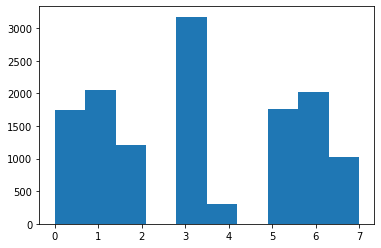

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 10, 13),
 datetime.date(2022, 10, 1),
 datetime.date(2012, 10, 3),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 10, 13), datetime.date(2022, 10, 1))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_65503/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_65503/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_65503/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_65503/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
A,1.000262,0.995078,1.000774,1.000404,1.000741,1.001237,1.002063,1.001955,1.015288
AA,1.000248,0.994133,1.000608,1.000886,1.001289,1.000247,1.001361,1.001320,1.000923
AAIC,0.999479,0.992777,1.000851,1.000104,1.001168,1.000681,1.001212,1.000123,1.016851
AAL,0.999904,0.993471,0.999123,1.002933,1.000689,1.002763,0.999160,1.002232,1.021372
AAME,0.999981,0.995969,1.000136,1.001095,1.000599,1.000759,1.001205,1.000046,1.001474


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
ZTEK,1.000568,0.998714,0.997767,0.999655,1.006490,0.996566,1.003775,0.998296,1.053500
ZTR,1.000187,0.998326,1.000077,1.000270,1.000708,1.000685,1.000598,1.000720,1.001312
ZUMZ,1.000125,0.995309,0.999619,1.001651,1.000206,1.001211,1.002081,1.001395,1.003766
ZWS,1.000077,0.992719,1.000770,0.997106,1.001033,1.003140,1.000948,1.001913,1.018402
ZYXI,1.000418,0.997531,1.001246,1.001063,1.000528,0.995907,0.997205,1.003333,1.019063


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
CURRENT_STATE# = 0

1

In [33]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]

df['weighted'] = {
    0: (0.6*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.3*df.dar),
    1: (0.5*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.3*df.dar)
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
ELC,1.001292,0.997846,1.008765,0.996780,1.000695,1.003420,1.000574,1.001273,0.990015,1.004232
DTST,1.000530,0.998808,1.002593,1.006583,0.996700,1.005935,0.997076,1.000241,1.045442,1.001994
GGE,1.000491,0.993466,1.005111,0.999278,1.003032,1.007133,1.001618,0.999167,0.975972,1.001977
LFMD,1.000371,0.997888,1.004401,0.998066,1.002945,0.999471,0.998106,0.999417,0.991537,1.001907
ENPH,1.001375,0.991102,1.004881,0.997557,1.001515,1.008333,1.001930,1.003143,1.004983,1.001719


In [34]:
df.mean(), df.median()

(dar         1.000158
 dar_0       0.996236
 dar_1       1.000237
 dar_2       1.000627
 dar_3       1.000888
 dar_4       1.001126
 dar_5       1.001118
 dar_6       1.000967
 dar_7       1.008956
 weighted    0.999850
 dtype: float64,
 dar         1.000242
 dar_0       0.996372
 dar_1       1.000344
 dar_2       1.000656
 dar_3       1.000921
 dar_4       1.001053
 dar_5       1.001100
 dar_6       1.000956
 dar_7       1.007209
 weighted    1.000013
 dtype: float64)

In [44]:
exclude = {
    0: [],
    1: [
        'ELC', 'FSI']}

In [45]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [46]:
print(sorted(best_weighted))

['AMRC', 'AMZN', 'BAH', 'CF', 'COOP', 'CSIQ', 'CTSH', 'CVE', 'DTST', 'ENPH', 'GCBC', 'GGE', 'LFMD', 'MOBQ', 'NTAP', 'RFP', 'SOBR', 'TJX', 'TSLA', 'VTSI']


In [47]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
DTST,1.000530,0.998808,1.002593,1.006583,0.996700,1.005935,0.997076,1.000241,1.045442,1.001994
GGE,1.000491,0.993466,1.005111,0.999278,1.003032,1.007133,1.001618,0.999167,0.975972,1.001977
LFMD,1.000371,0.997888,1.004401,0.998066,1.002945,0.999471,0.998106,0.999417,0.991537,1.001907
ENPH,1.001375,0.991102,1.004881,0.997557,1.001515,1.008333,1.001930,1.003143,1.004983,1.001719
SOBR,0.999977,1.000744,1.003814,0.996586,1.001448,0.997631,1.002350,0.995057,1.096325,1.001633
CVE,1.001407,0.995172,1.000507,1.013098,0.999292,0.999897,1.001472,0.999894,1.023717,1.001503
COOP,1.000468,0.994873,1.003673,0.999387,1.002494,1.002169,0.998509,1.000268,1.020268,1.001403
AMRC,1.000612,0.992585,1.003962,0.999656,1.001505,0.999350,1.001533,1.001865,1.017342,1.001389
TSLA,1.001651,0.992334,1.002755,1.001746,1.005402,1.003611,1.002384,1.002268,1.010161,1.001280
AMZN,1.001105,0.995578,1.002209,1.002687,1.001813,0.999111,1.002019,1.002026,1.013306,1.001262


In [48]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [49]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMRC,AMZN,BAH,CF,COOP,CSIQ,CTSH,CVE,DTST,ENPH,GCBC,GGE,LFMD,MOBQ,NTAP,RFP,SOBR,TJX,TSLA,VTSI
Date,,,,,,,,,,,,,,,,,,,,
2022-09-26,68.220001,115.150002,92.690002,90.360001,39.970001,36.439999,58.689999,14.60,2.07,274.920013,60.590000,1.68,1.92,1.14,62.610001,20.17,1.45,60.310001,276.010010,5.76
2022-09-27,66.239998,114.410004,92.150002,95.870003,40.110001,38.509998,57.970001,14.85,2.09,284.809998,60.619999,1.56,1.87,1.18,62.529999,20.02,1.35,60.570000,282.940002,5.60
2022-09-28,69.889999,118.010002,93.459999,100.209999,41.189999,39.139999,59.259998,15.61,2.08,292.309998,60.840000,1.30,2.04,1.27,63.700001,20.02,2.47,62.310001,287.809998,5.60
2022-09-29,63.810001,114.800003,92.180000,97.059998,39.980000,37.240002,58.450001,15.59,2.05,277.839996,60.500000,1.12,2.12,1.29,62.939999,20.01,1.93,61.340000,268.209991,5.43
2022-09-30,66.480003,113.000000,92.349998,96.250000,40.500000,37.250000,57.439999,15.37,2.04,277.470001,57.270000,1.10,1.97,1.16,61.849998,20.00,2.68,62.119999,265.250000,5.41


In [50]:
data = pd.concat([data, states], axis=1)

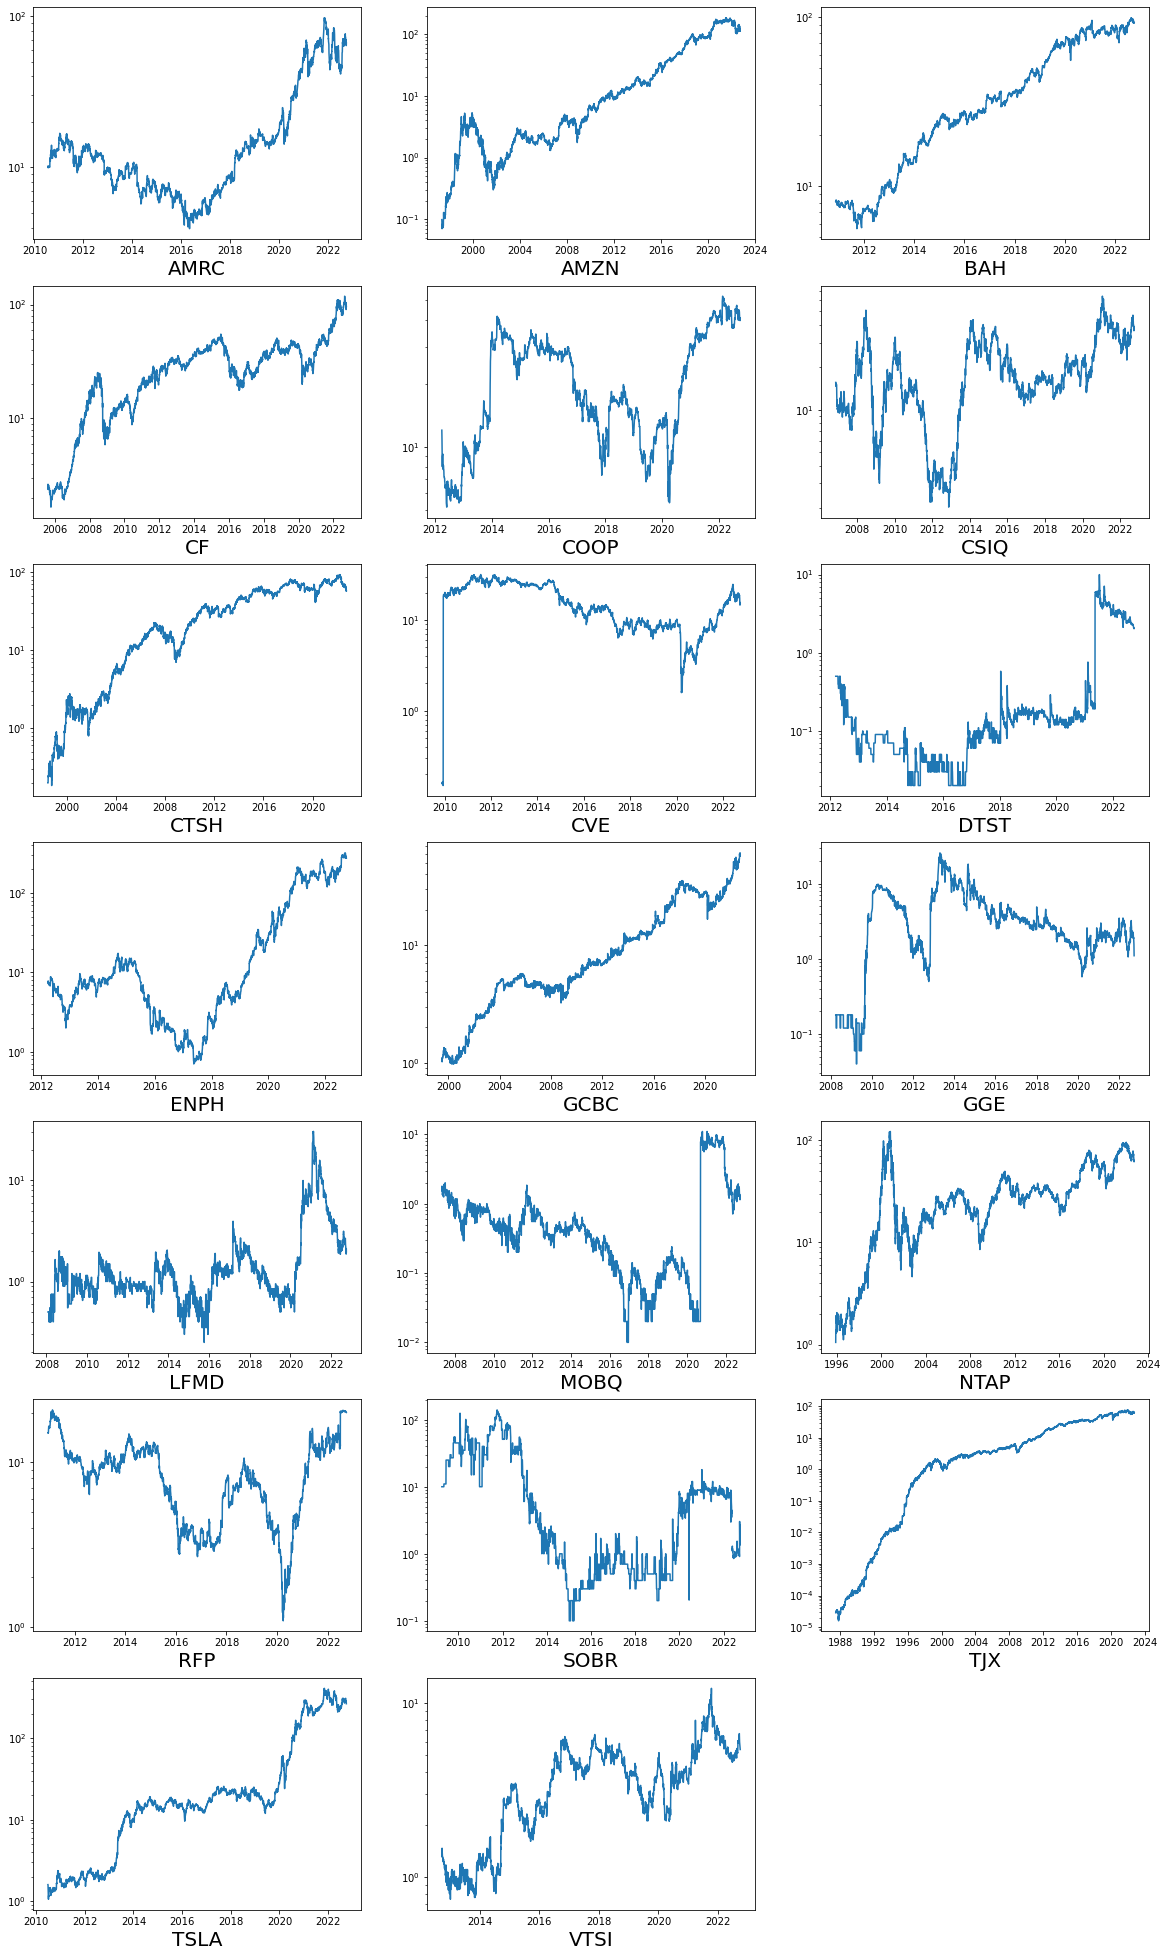

In [51]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

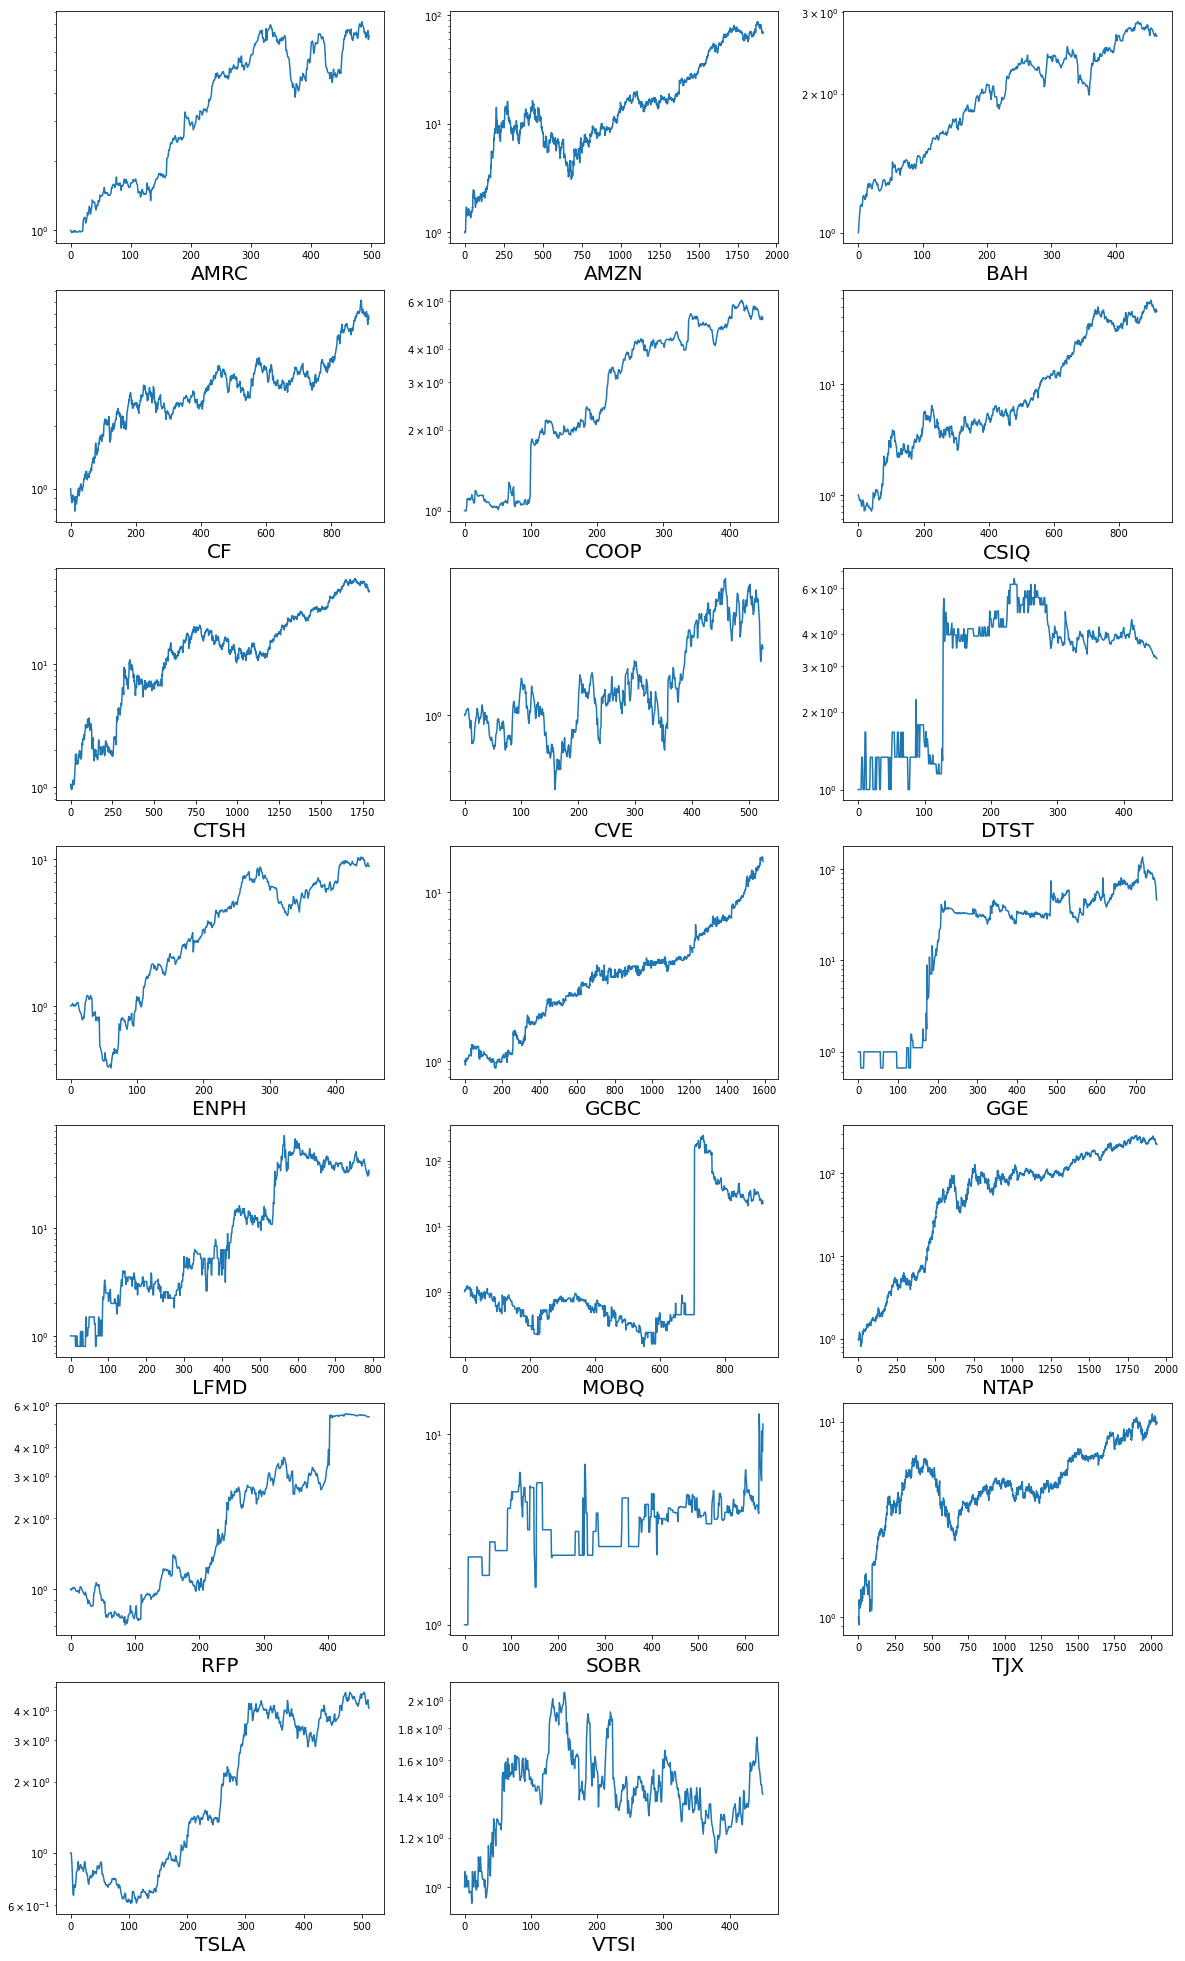

In [52]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [40]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()